In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
def replacer_ctype(text):
  if text=='GENERAL' or text=='general' or text=='Gen':
    return 'GEN'
  elif text=='sc':
    return 'SC'
  elif text=='st':
    return 'ST'
  else:
    return text

def replacer_sex(text):
  if text=='MALE' or text=='male':
    return 'M'
  elif text=='FEMALE' or text=='female':
    return 'F'
  else:
    return text

**Model for Classification: SVM**

I am using a aSupport Vector Machine for predicting whether a certain set of parameters ensures that a particular candidate will win or not.

These are some of the additional data cleaning steps followed:
1. Classifying the states on the basis of regions (https://en.wikipedia.org/wiki/Zonal_Councils_of_India) to ensure that dimensions do not become very high
2. Rather than predicting the position, I am predicting win or loss
3. One Hot Encoding for states and parties and Ordinal encoding for the other featues
4. Classifying parties on the basis of the number of candidates they have fielded. This is also done to reduce the dimensionality


In [3]:
def party_classify(party, freq, num):
  if freq[party]<=num:
    return 'other'
  else:
    return party

def party_formatter(text):
  arr= text.split()
  if len(arr)==1:
      return text.lower()
  else:
    string= ""
    for word in arr:
      string+= word[0]
    return string.lower()

def outcomes(num):
  if num==1:
    return 1
  else:
    return 0

def find_state_region(state):
    # Define the lists
    regions = {
        'North': ['Chandigarh', 'Delhi', 'Haryana', 'Himachal_Pradesh', 'Jammu_&_Kashmir', 'Punjab', 'Rajasthan'],
        'South': ['Andaman_&_Nicobar_Islands', 'Andhra_Pradesh', 'Karnataka', 'Kerala', 'Puducherry', 'Tamil_Nadu', 'Telangana', 'Lakshadweep'],
        'Central': ['Chhattisgarh', 'Madhya_Pradesh', 'Uttar_Pradesh', 'Uttarakhand'],
        'East': ['Bihar', 'Jharkhand', 'Odisha', 'West_Bengal'],
        'West': ['Dadra_&_Nagar_Haveli', 'Daman_&_Diu', 'Goa', 'Gujarat', 'Maharashtra'],
        'Northeast': ['Arunachal_Pradesh', 'Sikkim', 'Nagaland', 'Manipur', 'Mizoram', 'Tripura', 'Assam', 'Meghalaya']
    }

    # Check the state in each region
    for region, states in regions.items():
        if state in states:
            return region
    return None

In [4]:
#Data Cleaning

df_root= pd.read_csv("All_States_GE.csv")
df= df_root[((df_root['Year']==2019) | (df_root['Year']==2014) |(df_root['Year']==2009))]
df2 = df.drop(['Assembly_No', 'Constituency_No', 'Year', 'month', 'Poll_No', 'DelimID',
               'Valid_Votes', 'Electors', 'Sub_Region', 'N_Cand', 'Turnout_Percentage',
               'Margin', 'ENOP', 'pid', 'Party_ID', 'last_poll', 'Contested', 'Last_Party',
               'Last_Party_ID', 'Last_Constituency_Name', 'Same_Constituency', 'Same_Party',
               'No_Terms', 'TCPD_Prof_Main_Desc', 'TCPD_Prof_Second', 'TCPD_Prof_Second_Desc',
               'Election_Type', 'Deposit_Lost', 'Votes'], axis=1)
nota_df = df2[(df2['Candidate'] == 'NOTA') | (df2['Candidate'] == 'None of the Above')]
df3 = df2[(df2['Candidate'] != 'NOTA') & (df2['Candidate'] != 'None of the Above')]
df3['Candidate_Type'].fillna('GEN', inplace=True)
df4= df3.copy(deep=True)
df4['ctype']= df3['Candidate_Type'].apply(lambda x: replacer_ctype(str(x)))
df4['sex']= df3['Sex'].apply(lambda x: replacer_sex(str(x)))
df5= df4.drop(['Sex', 'Candidate_Type'], axis=1)
df6= df5[df5['sex']!='nan']

In [5]:
ml_df= df6.drop(['Candidate', 'Constituency_Name', 'Vote_Share_Percentage', 'Margin_Percentage',
       'Party_Type_TCPD', 'MyNeta_education', 'TCPD_Prof_Main'], axis=1)

ml_df2= ml_df.copy(deep=True)
ml_df2['party']=ml_df['Party'].apply(lambda x: party_formatter(str(x)))
ml_df2['outcome']=ml_df['Position'].apply(lambda x: outcomes(x))
ml_df2['region']=ml_df['State_Name'].apply(lambda x: find_state_region(x))

ml_df3= ml_df2.drop(['Party', 'Position', 'State_Name'], axis=1)

arr3 = ml_df3['party'].tolist()

party_count = {}

for party in arr3:
    if party not in party_count:
        party_count[party] = 1
    else:
        party_count[party] += 1

ml_df3['party_name']= ml_df3['party'].apply(lambda x: party_classify(str(x), party_count, 20))
ml_df4= ml_df3.drop(['party'], axis=1)

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

ml_df5 = ml_df4.copy(deep=True)
ordinal_encode_columns = ['Constituency_Type', 'ctype', 'sex', 'region']
label_encoder = LabelEncoder()
for col in ordinal_encode_columns:
    ml_df5[col] = label_encoder.fit_transform(ml_df5[col])
ml_df5 = pd.get_dummies(ml_df5, columns=['party_name'])

In [7]:
X = ml_df5.drop('outcome', axis=1)
y = ml_df5['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='rbf', C=10)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9500307188203972


In [8]:
arr= X.columns
for item in arr:
  print(item)

Constituency_Type
Turncoat
Incumbent
Recontest
ctype
sex
region
party_name_aaap
party_name_aapp
party_name_abhm
party_name_ad
party_name_admk
party_name_agp
party_name_aifb
party_name_aitc
party_name_aiudf
party_name_amb
party_name_anc
party_name_apoi
party_name_asp
party_name_audf
party_name_baresp
party_name_bbm
party_name_bhaprap
party_name_bjd
party_name_bjp
party_name_bmup
party_name_bscp
party_name_bsp
party_name_cpi
party_name_cpi(ml)(l)
party_name_cpim
party_name_cpm
party_name_dmdk
party_name_dmk
party_name_ggp
party_name_hjp
party_name_hnd
party_name_ijp
party_name_inc
party_name_ind
party_name_inld
party_name_iuml
party_name_jaspa
party_name_jd(s)
party_name_jd(u)
party_name_jdp
party_name_jgp
party_name_jknpp
party_name_jmbp
party_name_jmm
party_name_jnp
party_name_jps
party_name_jvm
party_name_kkjhs
party_name_ld
party_name_ljp
party_name_lsp
party_name_ltsd
party_name_madp
party_name_mnm
party_name_mns
party_name_nap
party_name_ncp
party_name_ntk
party_name_other
party_na

Mapping for column 'Constituency_Type':
GEN -> 0
SC -> 1
ST -> 2

Mapping for column 'ctype':
GEN -> 0
SC -> 1
ST -> 2

Mapping for column 'sex':
F -> 0
M -> 1
O -> 2

Mapping for column 'region':
Central -> 0
East -> 1
North -> 2
Northeast -> 3
South -> 4
West -> 5


In [9]:
import pandas as pd

def encode_party_name(Constituency_Type, Turncoat, Incumbent, Recontest, ctype, sex, region, party_name):
    # Create a dictionary with all party names and initialize them with 0
    arr= []
    if Constituency_Type=='GEN':
        arr.append(0)
    elif Constituency_Type=='SC':
        arr.append(1)
    else:
        arr.append(2)
    
    if Turncoat==True:
        arr.append(1)
    else:
        arr.append(0)
    
    if Incumbent==True:
        arr.append(1)
    else:
        arr.append(0)
    
    if Recontest==True:
        arr.append(1)
    else:
        arr.append(0)
    
    if ctype=='GEN':
        arr.append(0)
    elif ctype=='SC':
        arr.append(1)
    else:
        arr.append(2)
    
    if sex=='F':
        arr.append(0)
    elif sex=='M':
        arr.append(1)
    else:
        arr.append(2)

    if region=='Central':
        arr.append(0)
    elif region=='East':
        arr.append(1)
    elif region=='North':
        arr.append(1)
    elif region=='Northeast':
        arr.append(1)
    elif region=='South':
        arr.append(1)
    else:
        arr.append(1)

    # print(arr)

    party_names = [
        'aaap', 'aapp', 'abhm', 'ad', 'admk', 'agp', 'aifb', 'aitc', 'aiudf', 'amb', 'anc', 'apoi',
        'asp', 'audf', 'baresp', 'bbm', 'bhaprap', 'bjd', 'bjp', 'bmup', 'bscp', 'bsp', 'cpi', 'cpi(ml)(l)',
        'cpim', 'cpm', 'dmdk', 'dmk', 'ggp', 'hjp', 'hnd', 'ijp', 'inc', 'ind', 'inld', 'iuml', 'jaspa',
        'jd(s)', 'jd(u)', 'jdp', 'jgp', 'jknpp', 'jmbp', 'jmm', 'jnp', 'jps', 'jvm', 'kkjhs', 'ld', 'ljp',
        'lsp', 'ltsd', 'madp', 'mnm', 'mns', 'nap', 'ncp', 'ntk', 'other', 'pecp', 'pmk', 'ppid', 'ppoi',
        'prap', 'prcp', 'pspl', 'rdmp', 'rjd', 'rksp', 'rld', 'rpi', 'rpi(a)', 'rsmd', 'rsp', 'rsps', 'rws',
        'sad', 'sap', 'sbsp', 'sdpi', 'shs', 'sjp(r)', 'sp', 'suci', 'suci(c)', 'tdp', 'trs', 'upjp', 'vba',
        'wpoi', 'ysrcp'
    ]
    party_name_dict = {name: 0 for name in party_names}

    # Set the specified party name to 1
    party_name_dict[party_name] = 1

    # Create a DataFrame from the dictionary and transpose it to get the one-hot encoded array
    party_name_array = pd.DataFrame([party_name_dict]).T.values.flatten()
    encoded_array = arr + party_name_array.tolist()


    return encoded_array

In [10]:
encoded_party = encode_party_name('SC', True, False, False, 'SC', 'O', 'South', 'bjp')
svm_model.predict([encoded_party])

array([0], dtype=int64)

**Observation 1:**

Checking impact of BJP in South India, we will generate combinations of other parameters and check the outcome.  

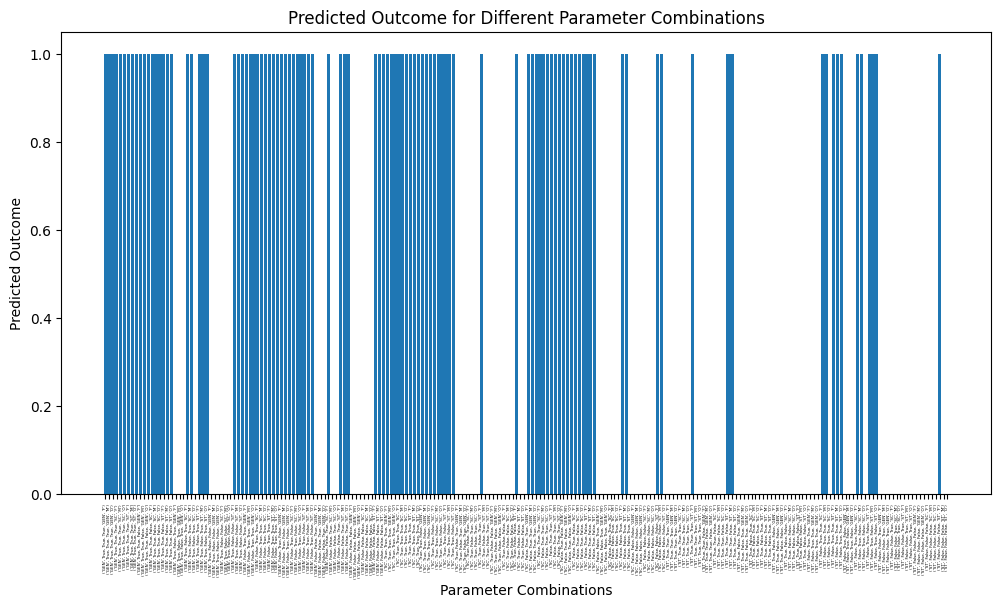

('GEN', True, True, True, 'GEN', 'F')
('GEN', True, True, True, 'GEN', 'M')
('GEN', True, True, True, 'GEN', 'O')
('GEN', True, True, True, 'SC', 'F')
('GEN', True, True, True, 'SC', 'M')
('GEN', True, True, True, 'SC', 'O')
('GEN', True, True, True, 'ST', 'F')
('GEN', True, True, True, 'ST', 'M')
('GEN', True, True, True, 'ST', 'O')
('GEN', True, True, False, 'GEN', 'F')
('GEN', True, True, False, 'GEN', 'M')
('GEN', True, True, False, 'GEN', 'O')
('GEN', True, True, False, 'SC', 'F')
('GEN', True, True, False, 'SC', 'M')
('GEN', True, True, False, 'SC', 'O')
('GEN', True, True, False, 'ST', 'F')
('GEN', True, True, False, 'ST', 'M')
('GEN', True, True, False, 'ST', 'O')
('GEN', True, False, True, 'SC', 'F')
('GEN', True, False, True, 'SC', 'M')
('GEN', True, False, True, 'ST', 'F')
('GEN', True, False, True, 'ST', 'M')
('GEN', True, False, True, 'ST', 'O')
('GEN', True, False, False, 'ST', 'F')
('GEN', True, False, False, 'ST', 'M')
('GEN', True, False, False, 'ST', 'O')
('GEN', Fals

In [11]:
import itertools

Constituency_Type_values = ['GEN', 'SC', 'ST']
Turncoat_values = [True, False]
Incumbent_values = [True, False]
Recontest_values = [True, False]
ctype_values = ['GEN', 'SC', 'ST']
sex_values = ['F', 'M', 'O']
national_parties= ['bjp','bsp','aitc','ncp','cpi','cpim','inc']
regions=['North','East','Northeast','South','West','Central']

combinations = itertools.product(
    Constituency_Type_values, Turncoat_values, Incumbent_values, Recontest_values,
    ctype_values, sex_values
)

outcomes = []
labels = []
pos_come= []
# Loop through each combination, encode the party_name, and predict the outcome
for comb in combinations:
    encoded_party = encode_party_name(*comb, 'South', 'bjp')
    outcome = svm_model.predict([encoded_party])
    outcomes.append(outcome)
    labels.append(str(comb))
    if outcome==1:
        pos_come.append(comb)

# Convert the outcomes and labels lists into numpy arrays for plotting
outcomes = np.array(outcomes).flatten()
labels = np.array(labels)

# Plot the outcomes
plt.figure(figsize=(12, 6))
plt.bar(labels, outcomes)
plt.xticks(rotation=90, fontsize=3)
plt.xlabel('Parameter Combinations')
plt.ylabel('Predicted Outcome')
plt.title('Predicted Outcome for Different Parameter Combinations')
plt.show()

for utem in pos_come:
    print(utem)

In [12]:
count=0
tlen= len(pos_come)
for item in pos_come:
    if item[2]==True:
        count+=1
print(count/tlen)

0.794392523364486


In [13]:
#As we see, 80% of the outcome=1 BJP candidates from South India are incumbents
for item in pos_come:
    if item[2]==False:
        if (item[0]=='SC' or item[0]=='ST') and (item[0]!=item[4]):
            continue
        else:
            print(item)

('GEN', True, False, True, 'SC', 'F')
('GEN', True, False, True, 'SC', 'M')
('GEN', True, False, True, 'ST', 'F')
('GEN', True, False, True, 'ST', 'M')
('GEN', True, False, True, 'ST', 'O')
('GEN', True, False, False, 'ST', 'F')
('GEN', True, False, False, 'ST', 'M')
('GEN', True, False, False, 'ST', 'O')
('GEN', False, False, True, 'SC', 'F')
('GEN', False, False, True, 'ST', 'F')
('GEN', False, False, True, 'ST', 'M')
('GEN', False, False, True, 'ST', 'O')
('GEN', False, False, False, 'ST', 'F')
('GEN', False, False, False, 'ST', 'M')
('GEN', False, False, False, 'ST', 'O')
('ST', False, False, False, 'ST', 'F')


Based on EDA, we have seen that SC and ST candidates have rarely won General Seats so these outcome=1 candidates of BJP are realistically unprobable. Thus, majority of BJP's victories in South India are likely to be already incumbent candidates. 

**Observation 2:**
In this observation of how women candidates perform in elections, we have narrowed our focus to national parties as of 2019 to streamline the computation process. From the analysis, it becomes evident that among the national parties, women candidates from BJP and AITC had a higher likelihood of winning, as indicated by the model.

Furthermore, the distribution of women candidates across regions shows a nearly even spread, with 75 occurrences in the Central region and 62 occurrences in all other regions combined.

However, the model reveals that the number of women candidates winning in ST (Scheduled Tribe) constituencies is the lowest compared to other regions.

In [14]:
combinations2= itertools.product(
    Constituency_Type_values, Turncoat_values, Incumbent_values, Recontest_values,
    ctype_values, ['F'], regions, national_parties 
)

women_victory= []
for comb2 in combinations2:
    outcome2= svm_model.predict([encode_party_name(*comb2)])
    if outcome2==1:
        women_victory.append(comb2)

In [15]:
victdf= pd.DataFrame(women_victory)
counts_dict = {}
for column in victdf.columns:
    counts_dict[column] = victdf[column].value_counts()

for column, counts in counts_dict.items():
    print(f"Counts for {column}:")
    print(counts)
    print()

Counts for 0:
GEN    162
SC     142
ST      70
Name: 0, dtype: int64

Counts for 1:
False    223
True     151
Name: 1, dtype: int64

Counts for 2:
True     283
False     91
Name: 2, dtype: int64

Counts for 3:
True     207
False    167
Name: 3, dtype: int64

Counts for 4:
ST     155
SC     116
GEN    103
Name: 4, dtype: int64

Counts for 5:
F    374
Name: 5, dtype: int64

Counts for 6:
Central      79
North        59
East         59
Northeast    59
South        59
West         59
Name: 6, dtype: int64

Counts for 7:
bjp     277
aitc     97
Name: 7, dtype: int64



**Observation 3:**

Turncoats are most succesful when they move to BJD, followed by BJP and AITC. 

In [16]:
all_parties= [
    'aaap', 'aapp', 'abhm', 'ad', 'admk', 'agp', 'aifb', 'aitc', 'aiudf', 'amb', 'anc', 'apoi',
    'asp', 'audf', 'baresp', 'bbm', 'bhaprap', 'bjd', 'bjp', 'bmup', 'bscp', 'bsp', 'cpi', 'cpi(ml)(l)',
    'cpim', 'cpm', 'dmdk', 'dmk', 'ggp', 'hjp', 'hnd', 'ijp', 'inc', 'ind', 'inld', 'iuml', 'jaspa',
    'jd(s)', 'jd(u)', 'jdp', 'jgp', 'jknpp', 'jmbp', 'jmm', 'jnp', 'jps', 'jvm', 'kkjhs', 'ld', 'ljp',
    'lsp', 'ltsd', 'madp', 'mnm', 'mns', 'nap', 'ncp', 'ntk', 'other', 'pecp', 'pmk', 'ppid', 'ppoi',
    'prap', 'prcp', 'pspl', 'rdmp', 'rjd', 'rksp', 'rld', 'rpi', 'rpi(a)', 'rsmd', 'rsp', 'rsps', 'rws',
    'sad', 'sap', 'sbsp', 'sdpi', 'shs', 'sjp(r)', 'sp', 'suci', 'suci(c)', 'tdp', 'trs', 'upjp', 'vba',
    'wpoi', 'ysrcp'
]

combinations3= itertools.product(
    Constituency_Type_values, [True], Incumbent_values, Recontest_values,
    ctype_values, sex_values, regions, all_parties 
)

turncoat_victory= []
for comb3 in combinations3:
    outcome3= svm_model.predict([encode_party_name(*comb3)])
    if outcome3==1:
        turncoat_victory.append(comb3)

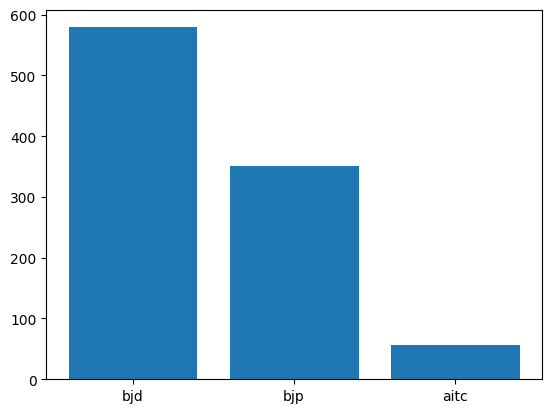

In [17]:
vict2df= pd.DataFrame(turncoat_victory)
counts_dict = vict2df[7].value_counts().to_dict()
plt.bar(counts_dict.keys(), counts_dict.values())
plt.show()

This is the code used for optimising the hyperparameters:

```
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.svm import SVC

svm_model = SVC()
param_grid = {
    'C': [0.1, 1, 10],    
    'kernel': ['linear', 'rbf', 'poly'],
}
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring=make_scorer(f1_score))
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Model Accuracy:", accuracy)```

xxk'


The accuracy of the model is 95% and on the basis of random testing, the accuracy consistently stays above 93%. The SVM model trued using RBF, Linear and Polynomial Kernels and was optimised using GridSearchCV. The data splits are as follows: Constituency_Type, Turncoat, 
Incumbent, Recontest, ctype (candidate being SC/ST/GEN), sex, region which will predict the outcome- ie whether  candidate is likely to win or not. 